# Water flow in soil - Numerical solutions in DuMu${}^x$

_by Daniel Leitner, Timo Koch, Andrea Schnepf_

In the following we will give some hints how to solve Benchmarks 1-4, using [DuMu${}^x$](www.dumux.org). The source code of the following 1D benchmarking examples is available on [Github](https://github.com/Plant-Root-Soil-Interactions-Modelling/dumux-rosi.git), in the folder dumux-rosi/rosi_benchmarking/richards1d/.

## Theory

We base our Dumux implementation on the [Richards Problem](http://www.dumux.uni-stuttgart.de/doxygen-stable/html-2.12/a01911.php) which states the Richards equation in the following form:
\begin{eqnarray} 
\frac{\partial}{\partial t} \left( \phi S \rho \right) - \frac{\partial}{\partial z}  \left[\rho \frac{\kappa}{\mu} K_s \left(\frac{\partial \psi}{\partial z} - \rho g \right) \right] = 0,
\end{eqnarray}
where $\rho$ is the fluid density, $S$ is the fluid saturation, $\phi$ is the porosity, $\kappa$ is the relative permeability, $\mu$ the dynamic viscosity, $K_s$ the intrinsic permeability, $\psi$ the fluid pressure and $g$ the gravitational acceleration. The quantities $S$ and $\psi$ are related by the water retention curve, i.e. $S=f^{-1}(\psi_{ref}-\psi) $

Introducing the hydraulic conductivity $K_c = K \ \rho \ g / \mu$, with $K = \kappa \ K_s$, and the water content $\theta = \phi \ S$ the equation takes the form 
\begin{eqnarray} 
\frac{\partial}{\partial t} \left( \rho \theta \right) = \frac{\partial}{\partial z}  \left[ K_c \frac{1}{g} \left(\frac{\partial \psi}{\partial z} - \rho g \right) \right].
\end{eqnarray}

Using the pressure head $h = (\psi-\psi_{ref})/(\rho \ g)$ leads to
\begin{eqnarray} 
\frac{\partial}{\partial t} \left( \rho \theta \right) = \frac{\partial}{\partial z}  \left[ \rho K_c \left(\frac{\partial h}{\partial z} - 1 \right) \right],
\end{eqnarray}
and dividing the equation by $\rho$ leads to the Richards equation, as presented in [Water flow in soil](Soil water flow.ipynb) (the fluid density $\rho$ must be constant in space and time). 

## Implementation

For implementation of the Benchmarks 1-4, we have to convert the parameters, overwrite the problem class defining initial conditions and boundary conditions, and manage the parameters using an input file. 


TODO description of relevant C++ code pieces 

## 1D

First the path must be set to the build-cmake/ folder, if we want to run Dumux from the Jupyter notebook. 

In [69]:
path = "/home/daniel/workspace/DUMUX/dumux-rosi/build-cmake/rosi_benchmarking/richards1d/" 

For producing the 1D geometries used in Benchmarks 1-4, we use the following function, where _N_ is the resolution, _depth_ (m) is the soil profile length, _top_ and _bot_ define the initial soil potential with a linear slope in cm pressure head, and _domainId_ is the index used if the soil profile consists of layers with different soil types. 

In [70]:
import numpy as np

def createDGF_1D(filename, N, depth, top, bot, domainId):

    z_ = np.linspace(0,-depth,N)
    initial = np.linspace(top,bot,N) # per node
    initialC = np.linspace(top,bot,N-1) # per cell    
    id = range(0,N)               
        
    file = open(filename,"w")     
    file.write("DGF\nVertex\n")
    file.write('parameters 2\n') # initial data, domain index 
    for i in range(0,N):
        file.write('{:g} {:g} {:g}\n'.format(z_[i], initial[i], domainId[i]))
             
    file.write('#\nSimplex\n') 
    file.write('parameters 2\n') # initial data, domain index 
    for i in range(0,N-1):
        file.write('{:g} {:g} {:g} {:g}\n'.format(id[i], id[i+1], initialC[i], domainId[i]));
                   
    file.write('#\nBOUNDARYSEGMENTS\n') # not used... 
    file.write('2 0\n')            
    file.write('3 {:g}\n'.format(N-1)) # vertex id, index starts with 0
    file.write('#\nBOUNDARYDOMAIN\ndefault 1\n#\n')
    file.close() 

For analysing the results we must read the DuMu${}^x$ VTP output. VTK for Pyhton is needed, to execute the follwoing code:

In [71]:
import vtk

def read_polydata(name):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(name)
    reader.Update()   
    polydata = reader.GetOutput() 
    return polydata

def read1D_vtp_data(name, cell = True):
    polydata = read_polydata(name)     
    if cell: 
        data = polydata.GetCellData()
    else:
        data = polydata.GetPointData()        
    nocd = data.GetNumberOfArrays()
    p = data.GetArray(2) # pressure   
    noa = p.GetNumberOfTuples()    
    p_ = np.ones(noa,)
    for i in range(0,noa):    
        d = p.GetTuple(i)
        p_[i] = d[0]            
    return p_

and auxiliary functions for later conversions:

In [72]:
g = 9.81 # gravitational acceleration (m/s^2)   
rho = 1.e3 # density of water, (kg/m^3)      
ref = 1.e5 # reference pressure (kg/ (m s^2))

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return (pa-ref) * 100 / rho / g

# class containing the van genuchten parameters
class Parameters:
    def __init__(self, R, S, alpha, n, Ksat):
        self.theta_R = R
        self.theta_S = S        
        self.alpha = alpha # [1/cm]         
        self.n = n
        self.m = 1.-1./n
        self.Ksat = Ksat       

# returns the volumetric water content at a given pressure head  according to the van genuchten model (Eqn 21)
def water_content(h, sp):
    return sp.theta_R + (sp.theta_S-sp.theta_R)/pow(1. + pow(sp.alpha*abs(h),sp.n),sp.m)

sand = Parameters(0.045, 0.43, 0.15, 3, 1000) 
loam = Parameters(0.08, 0.43, 0.04, 1.6, 50)
clay = Parameters(0.1, 0.4, 0.01, 1.1, 10)

### Benchmark 1

First we create a suitable geometry by writing a DGF (Dune Grid file) using the function defined above

In [34]:
domain_b1 = np.hstack((np.ones(50,), 2*np.ones(151,)))
createDGF_1D(path+"grids/b1.dgf",201,2.,-200,-200.,domain_b1)

The input file must contain the the types boundary conditons used in the Benchmark 1

```
[BC_Top]
Type = 2 # constant flux
Value = 0.5 # [cm day-1]

[BC_Bot]
Type = 5 # free drainage
```

 and the Van Genuchten parameters, that are different for the three scenarios, e.g. loam over sand is given by:

```
[VanGenuchten]  
Qr = 0.08  0.045	
Qs = 0.43 0.43
alpha = 0.04  0.15 # [1/cm] 
n = 1.6  3
Ks = 5.7870e-06 1.1574e-04 # [m/s] 	
```

To simulate the three scenarios we run our Richards 1D code with the corresponding input files (you need to insert the right path in line 2 first)

In [35]:
import os
wd = os.getcwd()
os.chdir(path)
os.system( "./richards1d input/b1a.input")
os.system( "./richards1d input/b1b.input")
os.system( "./richards1d input/b1c.input")
os.chdir(wd)

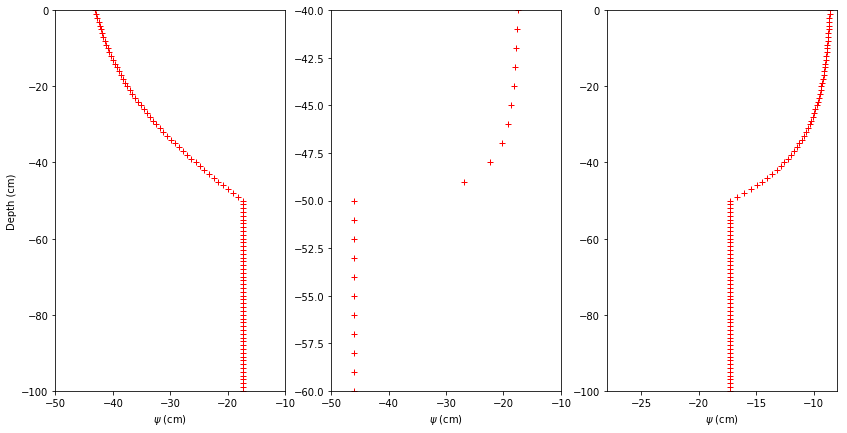

In [65]:
import matplotlib.pyplot as plt
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7)) 
pa_ = read1D_vtp_data(path+"benchmark1a-00001.vtp", False)
pb_ = read1D_vtp_data(path+"benchmark1b-00001.vtp", False)
pc_ = read1D_vtp_data(path+"benchmark1c-00001.vtp", False)
z_ = np.linspace(0,-200,len(pa_))
ax1.plot(toHead(pa_),z_, "r+")
ax2.plot(toHead(pb_),z_, "r+")
ax3.plot(toHead(pc_),z_, "r+")
ax1.set_xlabel('$\psi$ (cm)')
ax1.set_ylabel('Depth (cm)')
ax1. set_xlim(-50,-10)
ax1.set_ylim(-100,0)
ax2.set_xlabel('$\psi$ (cm)')
ax2.set_xlim(-50,-10)
ax2.set_ylim(-60,-40)
ax3.set_xlabel('$\psi$ (cm)')
ax3.set_xlim(-28,-8)
ax3.set_ylim(-100,0)
plt.show()

looks nice!

TODO we want to create an extra jupyter notebook to compare to the analytic solution

### Benchmark 2

We first crate the geometry with initial data linearly decreasing from 0 cm to -54 cm soil matric potential. 

In [50]:
createDGF_1D(path+"grids/b2.dgf",55,.54,-0,-54,np.ones(55,))

and choose the right boundary conditions, and Van Genuchten parameters in the input file

```
[VanGenuchten] 
# Loam: 
Qr = 0.08 
Qs = 0.43 
alpha = 0.04  # [1/cm] 
n = 1.6 
Ks = 5.7870e-06 # [m/s] hydrus verdoppelt

[BC_Top]
Type = 2 # constant flux
Value = -0.5 # [cm day-1]

[BC_Bot]
Type = 1 # constant pressure head
Value = 0 # [cm] fully saturated
```

Finally, we can simulate Benchmark 2, 

In [61]:
wd = os.getcwd()
os.chdir(path)
os.system( "./richards1d input/b2.input")
os.chdir(wd)

and visualize the results: 

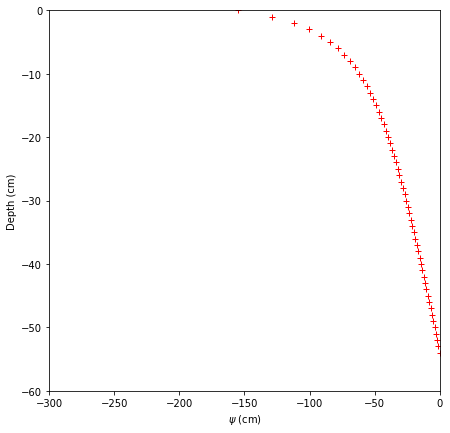

In [62]:
fig=plt.figure(figsize=(7, 7))
p_ = read1D_vtp_data(path+"benchmark2-00001.vtp", False)
z_ = np.linspace(0,-54,len(p_))
plt.plot(toHead(p_),z_, "r+") 
plt.xlabel('$\psi$ (cm)');
plt.ylabel('Depth (cm)');
plt.xlim(-300,0)
plt.ylim(-60,0)
plt.show()

### Benchmark 3

The four scenarios of Benchmark 3 have all the same geometry (2 m soil profile, -400 cm intial matric potential)

In [64]:
createDGF_1D(path+"grids/b3.dgf",201,2.,-400,-400.,np.ones(201,))

Simulate Benchmark 3 

In [75]:
os.chdir(path)
os.system( "./richards1d input/b3a.input")
os.system( "./richards1d input/b3b.input")
os.system( "./richards1d input/b3c.input")
os.chdir(wd)

Open results and prepare plot 

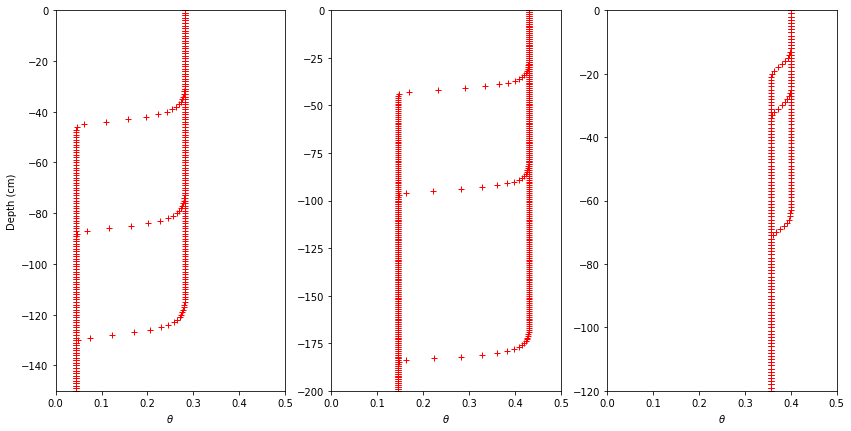

In [82]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax = [ax1,ax2,ax3]
z_ = np.linspace(0,-200,201)

# Figure 4a
for i in range(0,3):
    p_ = read1D_vtp_data(path+"benchmark3a-0000"+str(i+1)+".vtp", False)
    h_ = toHead(p_) 
    theta_ = water_content(h_, sand)
    ax1.plot(theta_,z_, "r+")   
# Figure 4b
for i in range(0,3):
    p_ = read1D_vtp_data(path+"benchmark3b-0000"+str(i+1)+".vtp", False)
    h_ = toHead(p_) 
    theta_ = water_content(h_, loam)
    ax2.plot(theta_,z_, "r+")
# Figure 4c
for i in range(0,3):
    p_ = read1D_vtp_data(path+"benchmark3c-0000"+str(i+1)+".vtp", False)
    h_ = toHead(p_) 
    theta_ = water_content(h_, clay)
    ax3.plot(theta_,z_, "r+")

for a in ax:
    a.set_xlabel(r'$\theta$')
    a.set_xlim(0,0.5)

ax1.set_ylabel('Depth (cm)')
ax1.set_ylim(-150,0)
ax2.set_ylim(-200,0)
ax3.set_ylim(-120,0)

plt.show()

TODO Currently, I am cheating in subplot c

### Benchmark 4

TODO 